# Geometry-based eddy detection and tracking algorithm

1. Identify eddies in Gulf of Mexico during sample time period
2. Track the eddies during the time period  

Author: Martin Jang

Version: 1.0

## Setup

In [1]:
import numpy as np
from netCDF4 import Dataset, date2num
import matplotlib.pyplot as plt
from datetime import datetime
from detect_eddy import *
from utils import *
import pickle
from Vortex import Doublelist
import os
import sys

## Detection
Zonal and meridional surface velocity field is to be examined for eddy identification. The detection scheme is explained in more details in "detect_center.py" For this demo, one month period (January 2012) of HYCOM data is used.    

In [2]:
year = 2012

# Load latitude and longitude in Gulf of Mexico
Y, X = loadLatLon('GOM')

# Load num_time of corresponding year
# num_time is datetime in hours since 2000/01/01 00:00:00
with Dataset('gom_reanalysis.nc', 'r') as source:
    num_time = source['time/' + str(year)][:]
    units = source['time/' + str(year)].units
    calendar = source['time/' + str(year)].calendar

# Find num_time of first and last day of sample time period
num_year_start = date2num(datetime(year, 1, 1, 0, 0,), units, calendar)
num_year_end = date2num(datetime(year, 2, 1, 0, 0,), units, calendar)  

# Calculate number of days in each year
number_of_days = np.int((num_year_end - num_year_start) / 24)

# Initialize variables
detection = np.ma.zeros((number_of_days, 325, 430))
divergence = np.ma.zeros((number_of_days, 325, 430))
vorticity = np.ma.zeros((number_of_days, 325, 430))
okuboWeiss = np.ma.zeros((number_of_days, 325, 430))
uVel = np.ma.zeros((number_of_days, 325, 430))
vVel = np.ma.zeros((number_of_days, 325, 430))

# Initialize first day of each year
day_start = num_year_start

# Compute dx and dy
dx, dy = dxdy('GOM')

day_count = 0
while (day_start < num_year_end):
    day_end = day_start + 24
    time = np.where((day_start <= num_time) & (num_time < day_end))[0]
    day_start = day_end

    # Load velocity for each day of year
    u, v = loadVelocity_GOM(year, time)        
    
    # Detect eddy centers
    detection_result = detect_center(u, v)
    
    # Calculate divergence, vorticity, and Okuno-Weiss parameter
    div, vort, ow = dvo(u, v, dx, dy)    
    
    # Store results
    detection[day_count, :, :] = detection_result
    divergence[day_count, :, :] = div
    vorticity[day_count, :, :] = vort
    okuboWeiss[day_count, :, :] = ow
    uVel[day_count, :, :] = u
    vVel[day_count, :, :] = v
    
    day_count += 1
    print "Searching ({}/{})".format(day_count, number_of_days)

detect_eddy.py:85: RuntimeWarning: invalid value encountered in less
  if np.any((v_mag[i, j-a : j] - np.roll(v_mag[i, j-a : j], 1))[1:] > 0) or np.any((v_mag[i, j : j+a] - np.roll(v_mag[i, j : j+a], 1))[1:] < 0) or np.any(sign_change_mat1[i, j-a : j] != 0) or np.any(sign_change_mat1[i, j+1 : j+a] != 0):
detect_eddy.py:85: RuntimeWarning: invalid value encountered in greater
  if np.any((v_mag[i, j-a : j] - np.roll(v_mag[i, j-a : j], 1))[1:] > 0) or np.any((v_mag[i, j : j+a] - np.roll(v_mag[i, j : j+a], 1))[1:] < 0) or np.any(sign_change_mat1[i, j-a : j] != 0) or np.any(sign_change_mat1[i, j+1 : j+a] != 0):
detect_eddy.py:123: RuntimeWarning: invalid value encountered in greater
  if np.any((u_mag[i-a : i, j] - np.roll(u_mag[i-a : i, j], 1))[1:] > 0) or np.any((u_mag[i : i+a, j] - np.roll(u_mag[i : i+a, j], 1))[1:] < 0) or np.any(sign_change_mat2[i-a : i, j] != 0) or np.any(sign_change_mat2[i+1 : i+a, j] != 0):
detect_eddy.py:123: RuntimeWarning: invalid value encountered in less
  if 

Searching (1/31)
Searching (2/31)
Searching (3/31)
Searching (4/31)
Searching (5/31)
Searching (6/31)
Searching (7/31)
Searching (8/31)
Searching (9/31)
Searching (10/31)
Searching (11/31)
Searching (12/31)
Searching (13/31)
Searching (14/31)
Searching (15/31)
Searching (16/31)
Searching (17/31)
Searching (18/31)
Searching (19/31)
Searching (20/31)
Searching (21/31)
Searching (22/31)
Searching (23/31)
Searching (24/31)
Searching (25/31)
Searching (26/31)
Searching (27/31)
Searching (28/31)
Searching (29/31)
Searching (30/31)
Searching (31/31)


## Tracking

In [3]:
eddy_centers = detection.copy()
time_idx, lat_idx, lon_idx = eddy_centers.shape    

# Initialize eddy counter
eddy_counter = 0
# Set searching window width
searching_width = 21    # odd number; approx. 30 miles = 48km for GOM

for t in np.arange(time_idx):

    # Cyclonic eddy    
    for i, j in zip(*np.where(eddy_centers[t, :, :] == 1)):

        # Create a new eddy object
        eddy_counter += 1
        globals()["eddy_" + str(eddy_counter)] = Doublelist()

        # convert t to num_time
        num_time_t = date2num(datetime(year, 1, 1,), units, calendar) + t * 24
        
        # record num_time, lat, lon, and mode
        globals()["eddy_" + str(eddy_counter)].append(num_time_t, i, j, 1)

        # Place a check mark at the location by change 1 to NaN
        eddy_centers[t, i, j] = np.NaN

        # While switch is on, search and append to eddy track list if search is successful
        switch = True
        
        # Copy the time and location of current eddy
        search_day = t.copy(); search_lat_idx = i.copy(); search_lon_idx = j.copy()
        while switch:
            # Look for an eddy or eddies inside the searching window
            search_day, search_lat_idx, search_lon_idx = search(search_day, search_lat_idx, search_lon_idx, 1, searching_width, eddy_centers, time_idx)             
            if search_day != None:
                # convert search_day to num_time
                num_time_search_day = date2num(datetime(year, 1, 1,), units, calendar) + search_day * 24
                
                # record num_time, lat, lon, and mode
                globals()["eddy_" + str(eddy_counter)].append(num_time_search_day, search_lat_idx, search_lon_idx, 1)

                # Place a check mark at the location by change 1 to NaN
                eddy_centers[search_day, search_lat_idx, search_lon_idx] = np.NaN
            else:
                switch = False

    # Anti-cyclonic eddy    
    for i, j in zip(*np.where(eddy_centers[t, :, :] == -1)):

        # Create new eddys
        eddy_counter += 1
        globals()["eddy_" + str(eddy_counter)] = Doublelist()

        # convert t to num_time
        num_time_t = date2num(datetime(year, 1, 1,), units, calendar) + t * 24
        
        # record num_time, lat, lon, and mode
        globals()["eddy_" + str(eddy_counter)].append(num_time_t, i, j, -1)

        # Place a check mark at the location by change 1 to NaN
        eddy_centers[t, i, j] = np.NaN

        # While switch is on, search and append to eddy track list if search is successful
        switch = True
        search_day = t.copy(); search_lat_idx = i.copy(); search_lon_idx = j.copy()
        while switch:
            # Look for an eddy or eddies inside the searching window
            search_day, search_lat_idx, search_lon_idx = search(search_day, search_lat_idx, search_lon_idx, -1, searching_width, eddy_centers, time_idx) 
            if search_day != None:

                # convert search_day to num_time
                num_time_search_day = date2num(datetime(year, 1, 1,), units, calendar) + search_day * 24
                
                # record num_time, lat, lon, and mode
                globals()["eddy_" + str(eddy_counter)].append(num_time_search_day, search_lat_idx, search_lon_idx, -1)

                # Place a check mark at the location by change 1 to NaN
                eddy_centers[search_day, search_lat_idx, search_lon_idx] = np.NaN
            else:
                switch = False

print "Total number of eddies detected: {}".format(eddy_counter)

Total number of eddies detected: 274


## View eddy track sample

The total number of eddies detected is equal to the number of eddy objects created. So, for example when 100 eddies are detected, 100 eddy objects (eddy_1, eddy_2, ...., eddy_100) would have been created and each eddy can be access by methods such as show(), lifetime(), mode(), and speed(). 

In [9]:
eddy_1.show()
print(eddy_1.lifetime())
print(eddy_1.mode())
print(eddy_1.speed())

Show list data: (day, lat, lon, rot)
(105192.0, 49, 72, 1)
(105216.0, 42, 79, 1)
(105240.0, 34, 85, 1)
(105264.0, 39, 88, 1)
(105288.0, 39, 89, 1)
**************************************************
5.0
cyclonic
[[105192.0 None]
 [105216.0 0.020608426450580093]
 [105240.0 0.021008633042476983]
 [105264.0 0.012319781398882157]
 [105288.0 0.0020185631202148013]]


## plot
Shows center of detected eddies with velocity field and vorticity dominant regions.

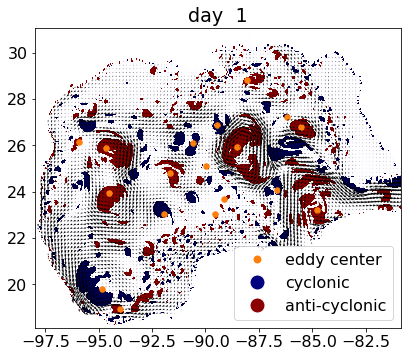

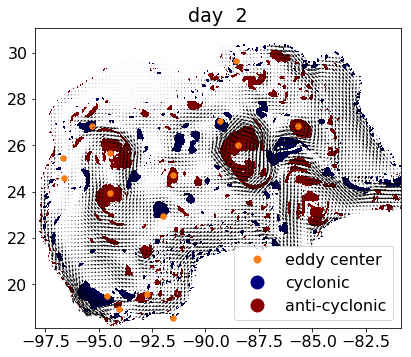

In [ ]:
for day in np.arange(3) + 1:    # choose between 1 ~ 31
    plt.figure()
    plotDetection(detection[day, :, :], vorticity[day, :, :], okuboWeiss[day, :, :], uVel[day, :, :], vVel[day, :, :], Y, X)
    plt.title('day {:2d}'.format(day))